In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import quantities as pq
from operator import itemgetter
from edog.tools import*
from edog.plot import*


filename = "params.yaml"
params = parse_parameters(filename)

nt, nr, dt, dr = itemgetter("nt", "nr", "dt", "dr")(params["grid"])

A_g, a_g, B_g, b_g = itemgetter("A", "a", "B", "b")(params["ganglion"])
phase, damping, delay_g = itemgetter("phase", "damping", "delay")(params["ganglion"])

w_rg, A_rg, a_rg = itemgetter("w", "A", "a")(params["relay"]["Krg"])
tau_rg, delay_rg = itemgetter("tau", "delay")(params["relay"]["Krg"])

## Feedforward excitation

In [2]:
network = create_spatiotemporal_network(nt=nt, nr=nr, dt=dt, dr=dr,
                                        A_g=A_g, a_g=a_g, B_g=B_g, b_g=b_g,
                                        phase=phase, damping=damping, delay_g=delay_g,
                                        w_rg=w_rg, A_rg=A_rg, a_rg=a_rg,
                                        tau_rg=tau_rg, delay_rg=delay_rg)

[relay] = get_neuron("Relay", network)
network.compute_irf(relay)

irf = relay.irf
positions = network.integrator.positions
times = network.integrator.times

-------------
## Plotting

### Settings

In [50]:
cmap = "RdBu_r"
interpolation = "none"
t_idx = [10, 30, 70, 85]
x_id = 30
t_id = 150
vmax = 0.3
vmin = -0.25
levels = np.hstack((np.linspace(vmin, vmin*0.05, 4), np.linspace(vmax*0.03, vmax, 4)))

Nt, Nx, Ny = irf.shape
fig = plt.figure(figsize=(8, 6))

# spatial receptive field
gs1 = gridspec.GridSpec(3, 8)
gs1.update(top=1.0, bottom=0.6, hspace=1.1)
ax1 = plt.subplot(gs1[:2, 0:2])
ax2 = plt.subplot(gs1[:2, 2:4], sharey=ax1)
ax3 = plt.subplot(gs1[:2, 4:6], sharey=ax1)
ax4 = plt.subplot(gs1[:2, 6:], sharey=ax1)

# 1d plots
ax5 = plt.subplot(gs1[-1, 0:2], sharex=ax1)
ax6 = plt.subplot(gs1[-1, 2:4], sharex=ax2, sharey=ax5)
ax7 = plt.subplot(gs1[-1, 4:6], sharex=ax3, sharey=ax5)
ax8 = plt.subplot(gs1[-1, 6:], sharex=ax4, sharey=ax5)

# x-t and time plot
gs2 = gridspec.GridSpec(2, 4)
gs2.update(top=0.45)
ax9 = plt.subplot(gs2[:, :2])
ax10 = plt.subplot(gs2[:, 2:])

plt.close()

### Spatial receptive field plots 2d

In [51]:
for ax, ti in zip([ax1, ax2, ax3, ax4], t_idx):
    extent = [positions[int(Nx/2-x_id)], positions[int(Nx/2+x_id)],
              positions[int(Nx/2-x_id)], positions[int(Nx/2+x_id)]]
    im = ax.imshow(irf[ti,
                       int(Nx/2-x_id):int(Nx/2+x_id),
                       int(Ny/2-x_id):int(Ny/2+x_id)],
                   cmap=cmap, extent=extent, origin="lower",
                   interpolation=interpolation, aspect="auto",
                   vmin=vmin, vmax=vmax,
                   norm=MidpointNormalize(midpoint=0.))

    ax.set_title(r"$t$="+str(times[ti]))

    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines['left'].set_color('none')
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.spines['bottom'].set_color('none')

    if ax is not ax1:
        plt.setp(ax.get_xticklabels(), visible=False)
        plt.setp(ax.get_yticklabels(), visible=False)
    else:
        ax.set_xlabel("$x$ (deg)")
        ax.set_ylabel("$y$ (deg)")
ax1.set_xticks([-3, 3])
ax1.set_yticks([-3, 3])

### Spatial receptive field plots 1d

In [52]:
for ax, ti in zip([ax5, ax6, ax7, ax8], t_idx):
    ax.fill_between(positions[int(Nx/2-x_id):int(Nx/2+x_id)], 0,
                    irf[ti, int(Nx/2-x_id):int(Nx/2+x_id), int(Ny/2)],
                    where=irf[ti, int(Nx/2-x_id):int(Nx/2+x_id), int(Ny/2)] >= 0,
                    facecolor='#a50f15', interpolate=True)

    ax.fill_between(positions[int(Nx/2-x_id):int(Nx/2+x_id)], 0,
                    irf[ti, int(Nx/2-x_id):int(Nx/2+x_id), int(Ny/2)],
                    where=irf[ti, int(Nx/2-x_id):int(Nx/2+x_id), int(Ny/2)] < 0,
                    facecolor='#045a8d', interpolate=True)

    ax.spines['left'].set_color('none')
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.spines['bottom'].set_position(('data', 0))
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    plt.setp(ax.get_xticklabels(), visible=False)
    plt.setp(ax.get_yticklabels(), visible=False)

### Dynamic receptive field plots

In [53]:
extent = [positions[int(Nx/2-x_id)].magnitude, positions[int(Nx/2+x_id)].magnitude,
          times[0].magnitude, times[t_id].magnitude]
im = ax9.imshow(irf[:t_id, int(Nx/2-x_id):int(Nx/2+x_id), int(Ny/2)],
                cmap=cmap, extent=extent, origin="lower",
                interpolation=interpolation, aspect="auto",
                vmin=vmin, vmax=vmax,
                norm=MidpointNormalize(midpoint=0.))

ax9.contour(irf[:t_id, int(Nx/2-x_id):int(Nx/2+x_id), int(Ny/2)],
            extent=extent, colors="grey", levels=levels)
ax9.set_xlabel("$x$ (deg)")
ax9.set_ylabel("Time (ms)")
ax9.set_title("Spatiotemporal receptive field")
ax9.xaxis.set_ticks_position('none')
ax9.yaxis.set_ticks_position('none')
ax9.spines['left'].set_color('none')
ax9.spines['right'].set_color('none')
ax9.spines['top'].set_color('none')
ax9.spines['bottom'].set_color('none')
ax9.set_xticks([-3, 0, 3])
ax9.set_xlim([-3, 3])
ax9.set_ylim([0, 100])

(0, 100)

### Time plot

In [54]:
ax10.plot(times[:t_id], irf[:t_id, int(Nx/2), int(Ny/2)])
ax10.set_xlabel("Time", x=1)
ax10.set_ylabel("Amplitude", y=0.8)

ax10.spines['left'].set_position(('data', 0))
ax10.spines['right'].set_color('none')
ax10.spines['top'].set_color('none')
ax10.spines['bottom'].set_position(('data', 0))
ax10.xaxis.set_ticks_position('none')
ax10.yaxis.set_ticks_position('none')
ax10.set_yticks([])
ax10.set_xticks([])

t_peak = times[np.argmax(irf[:t_id, int(Nx/2), int(Ny/2)])]
t_peak_2 = times[np.argmin(irf[:t_id, int(Nx/2), int(Ny/2)])]
R_max = irf[:t_id, int(Nx/2), int(Ny/2)].max()
R_min = irf[:t_id, int(Nx/2), int(Ny/2)].min()

ax10.scatter([t_peak, ], [0, ], 20, color="k")
ax10.annotate("", xy=(t_peak, 0), xycoords='data', xytext=(t_peak, R_max),
              textcoords='data', arrowprops={'arrowstyle': '<|-|>', 'linestyle': '-',
                                             'linewidth': 1, 'color': 'k'})
ax10.annotate("", xy=(t_peak_2, 0), xycoords='data', xytext=(t_peak_2, R_min),
              textcoords='data', arrowprops={'arrowstyle': '<|-|>', 'linestyle': '-',
                                             'linewidth': 1, 'color': 'k'})

ax10.annotate(r'$t_{\mathrm{peak}}$', xy=(t_peak, 0), xycoords='data', xytext=(-10, -30),
              textcoords='offset points', fontsize=18)

ax10.annotate(r'$P_{\mathrm{A}}$', xy=(t_peak, R_max/2), xycoords='data', xytext=(+1, 0),
              textcoords='offset points')

ax10.annotate(r'$P_{\mathrm{B}}$', xy=(t_peak_2, R_min/2), xycoords='data', xytext=(+2, -1),
              textcoords='offset points')

ax10.annotate(r'$\mathrm{Biphasic\;index} = \left|\frac{P_{\mathrm{B}}}{P_{\mathrm{A}}}\right|$',
              xy=(t_peak*2., R_max/2), xycoords='data', xytext=(+1, 0),
              textcoords='offset points')


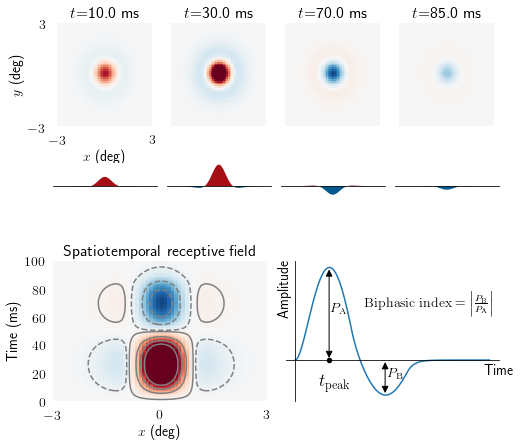

In [55]:
fig